# Adaptive Q-Learning in a 25×25 GridWorld (8 actions with probabilistic transitions)


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import sys
import os

# Add the utils directory to the Python path and import utils
from utils import *
from MLPQLearningAgent import *
from OracleQLearningAgent import *
from TransitionModelLearner import *

In [2]:
# Initialize the GridWorld environment with probabilistic transitions
# Probabilistic parameters:
# success_prob = 0.8: 80% chance of intended action
# noise_prob = 0.1: 10% chance of random action  
# stay_prob = 0.1: 10% chance of staying in place
grid_world = GridWorld(
    n_rows=25,
    n_cols=25,
    start=(0, 0),
    goal=(24, 24),
    walls = WALLS,
    step_reward=-0.1,
    goal_reward=1.0,
    gamma=0.95,
    success_prob=0.8,
    noise_prob=0.1,
    stay_prob=0.1
)

def oracle_model(s, action):
    """Oracle model that predicts the next state for diagonal actions (4-7)"""
    s_model_next, r_model, done_model = grid_world.step(grid_world.from_index(s), action, ACTIONS_8)
    return s_model_next

### Agent algorithms

## Probabilistic vs Deterministic Environment Comparison

The environment now supports **probabilistic transitions** with the following parameters:
- **Success probability (0.8)**: 80% chance the intended action is executed
- **Noise probability (0.1)**: 10% chance a random action is executed instead  
- **Stay probability (0.1)**: 10% chance the agent stays in the current position

This makes the environment more realistic and challenging compared to the previous deterministic version.

## **1. Q learning with 4 actions:**

In [3]:
# Q-learning with 4 actions using refactored approach
rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)

NUM_STATES = N_ROWS * N_COLS
NUM_ACTIONS_4 = 4
Q4 = np.zeros((NUM_STATES, NUM_ACTIONS_4), dtype=float)

returns = np.zeros(EPISODES, dtype=float)
bumps = np.zeros(EPISODES, dtype=float)
steps_arr = np.zeros(EPISODES, dtype=int)

eps = EPS_START
eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)

for ep in range(EPISODES):
    s = START
    si = grid_world.to_index(s)
    done = False
    G = 0.0
    bumpcount = 0
    disc = 1.0
    steps = 0

    for t in range(MAX_STEPS):
        a = epsilon_greedy(Q4[si], eps, rng)
        s_next, r, done = grid_world.step(s, a, ACTIONS_4, rng)
        s_next_i = grid_world.to_index(s_next)

        if si == s_next_i:
            bumpcount += 1
            r = BUMP_REWARD

        target = r if done else r + GAMMA * np.max(Q4[s_next_i])
        Q4[si, a] += ALPHA * (target - Q4[si, a])

        G += r
        disc *= GAMMA
        s, si = s_next, s_next_i
        steps += 1
        if done:
            break

    returns[ep] = G
    bumps[ep] = bumpcount
    steps_arr[ep] = steps
    if ep < EPS_DECAY_EPISODES:
        eps = max(EPS_END, eps - eps_decay)

print('Training (4 actions) complete!')
returns4 = returns.copy()
bumps4 = bumps.copy()
ma_w = 25
ret_ma4 = moving_average(returns4, w=ma_w)

policy4 = Visualizer.derive_policy(Q4, N_ROWS, N_COLS)
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(Q4, N_ROWS, N_COLS)

Training (4 actions) complete!

Policy Visualization:
 S  ↓  →  ▓  ↑  →  →  ↓  ↑  ↑  →  →  ▓  ↓  ↑  ↑  ←  →  ←  →  ↑  ←  ↑  ↓  → 
 →  ↓  →  →  →  →  ↑  →  →  ▓  ↓  ↓  ▓  →  ▓  ↓  ←  ←  ←  →  ↑  ←  →  ▓  ← 
 →  ↓  ▓  ←  ↑  ↓  ↑  ↓  ↑  →  ↓  →  ▓  ↑  ↑  ▓  →  ↑  ↓  ↓  ↓  ←  ↓  →  ↑ 
 ▓  ↓  →  ↑  ▓  →  →  →  ▓  ←  ↓  ↓  ▓  →  ▓  ↑  ←  →  →  ↓  ↓  ↓  ▓  →  ↑ 
 →  ←  ↓  ↑  ↓  →  ▓  ↓  ←  ▓  →  ↑  ↑  ↑  ▓  ↓  →  ↓  ▓  ↑  ↓  ▓  ↓  ↑  ↑ 
 ↓  ▓  →  →  ↓  ▓  ↓  ←  ↓  ↓  ▓  ▓  →  ↓  ↑  ↓  ↓  →  ↓  ▓  ←  ↓  ↑  ←  ↓ 
 ↓  ↓  ←  ↓  →  ▓  →  ▓  ↓  →  ↓  ▓  ▓  ←  ↓  ↓  ↓  →  ←  ▓  ▓  ↓  ←  →  ↓ 
 ←  →  ↑  ▓  →  ▓  ↑  ←  ↓  ▓  →  ↓  ▓  →  →  ↓  ▓  ↓  ←  ▓  ↓  ↓  ↓  ↑  ↓ 
 ←  ↓  ▓  ↓  ←  ▓  ↑  ←  ▓  ▓  ▓  ↓  ↑  →  ←  ↓  ▓  ↓  ←  ▓  ▓  ↓  ↓  ↓  → 
 ←  ↓  →  ↓  ↓  ▓  ↓  ←  ▓  ▓  ↓  ↓  ↓  ↓  ▓  ←  ↓  ↓  ▓  ▓  ↑  ↓  ←  ↓  → 
 →  →  →  ←  ↓  ▓  ▓  ▓  ↑  →  ▓  →  ←  →  →  →  ↓  ↓  ▓  →  ↓  ↓  ▓  ↓  ↓ 
 ←  ▓  ↑  ▓  ↓  ▓  ↓  ↑  →  ←  ←  ←  ↓  ↑  →  ▓  →  →  →  →  →  →  ↓  ←  ← 
 ▓  ▓  ▓  ↓  ↓  ▓  ↑  ←  ▓  ↓  ↓  

## Add 4 diagonal actions: South-East, South-West, North-East, North-West


In [4]:
# Demo: test all diagonal actions from (3,2) using the new action map
s_demo = (3, 2)
diagonal_actions = {
    4: 'SE (South-East)',
    5: 'SW (South-West)', 
    6: 'NE (North-East)',
    7: 'NW (North-West)'
}

print(f"Testing diagonal actions from position {s_demo}:")
for action, description in diagonal_actions.items():
    s_next_demo, r_demo, done_demo = grid_world.step(s_demo, action, ACTIONS_8)
    print(f'Action {action} {description}: {s_demo} -> {s_next_demo} | reward={r_demo} | done={done_demo}')

print("\nCurrent policy (with 4 actions only):")
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)

Testing diagonal actions from position (3, 2):
Action 4 SE (South-East): (3, 2) -> (4, 3) | reward=-0.1 | done=False
Action 5 SW (South-West): (3, 2) -> (4, 1) | reward=-0.1 | done=False
Action 6 NE (North-East): (3, 2) -> (2, 3) | reward=-0.1 | done=False
Action 7 NW (North-West): (3, 2) -> (2, 1) | reward=-0.1 | done=False

Current policy (with 4 actions only):

Policy Visualization:
 S  ↓  →  ▓  ↑  →  →  ↓  ↑  ↑  →  →  ▓  ↓  ↑  ↑  ←  →  ←  →  ↑  ←  ↑  ↓  → 
 →  ↓  →  →  →  →  ↑  →  →  ▓  ↓  ↓  ▓  →  ▓  ↓  ←  ←  ←  →  ↑  ←  →  ▓  ← 
 →  ↓  ▓  ←  ↑  ↓  ↑  ↓  ↑  →  ↓  →  ▓  ↑  ↑  ▓  →  ↑  ↓  ↓  ↓  ←  ↓  →  ↑ 
 ▓  ↓  →  ↑  ▓  →  →  →  ▓  ←  ↓  ↓  ▓  →  ▓  ↑  ←  →  →  ↓  ↓  ↓  ▓  →  ↑ 
 →  ←  ↓  ↑  ↓  →  ▓  ↓  ←  ▓  →  ↑  ↑  ↑  ▓  ↓  →  ↓  ▓  ↑  ↓  ▓  ↓  ↑  ↑ 
 ↓  ▓  →  →  ↓  ▓  ↓  ←  ↓  ↓  ▓  ▓  →  ↓  ↑  ↓  ↓  →  ↓  ▓  ←  ↓  ↑  ←  ↓ 
 ↓  ↓  ←  ↓  →  ▓  →  ▓  ↓  →  ↓  ▓  ▓  ←  ↓  ↓  ↓  →  ←  ▓  ▓  ↓  ←  →  ↓ 
 ←  →  ↑  ▓  →  ▓  ↑  ←  ↓  ▓  →  ↓  ▓  →  →  ↓  ▓  ↓  ←  ▓  ↓  ↓  ↓  ↑  ↓ 
 ← 

## **3. Q learning with 8 actions and an oracle model**

Running multiple experiments for statistical analysis...
Running experiment 1/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 2/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 3/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 4/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 5/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 6/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 7/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 8/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 9/10...
Training (4 actions) complete!
Training (8 actions) complete!
Running experiment 10/10...
Training (4 actions) complete!
Training (8 actions) complete!


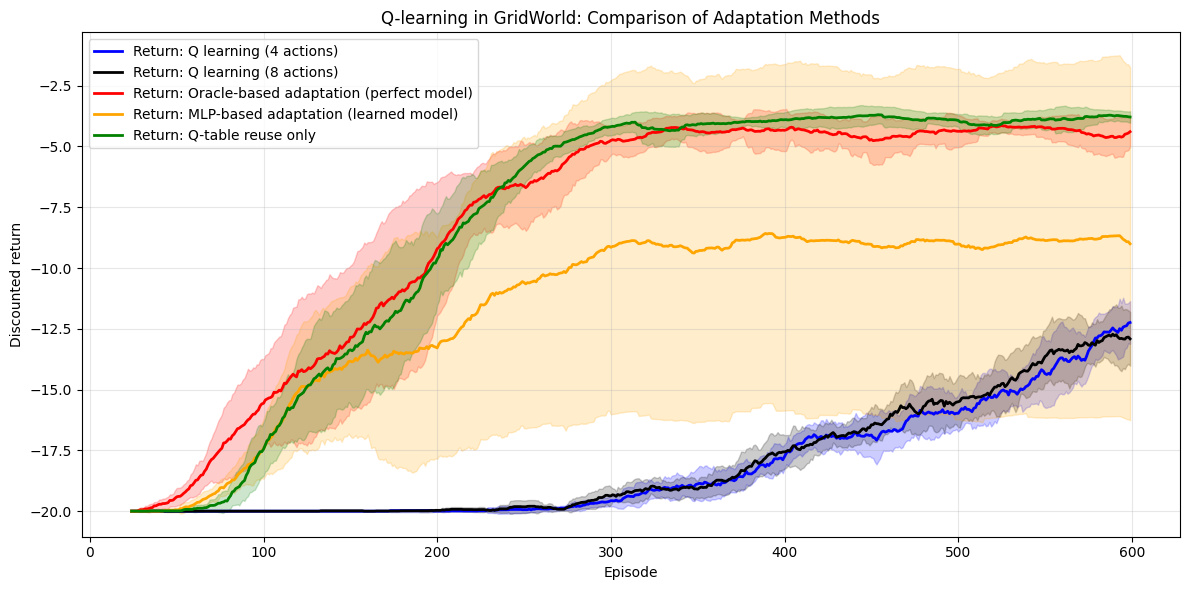

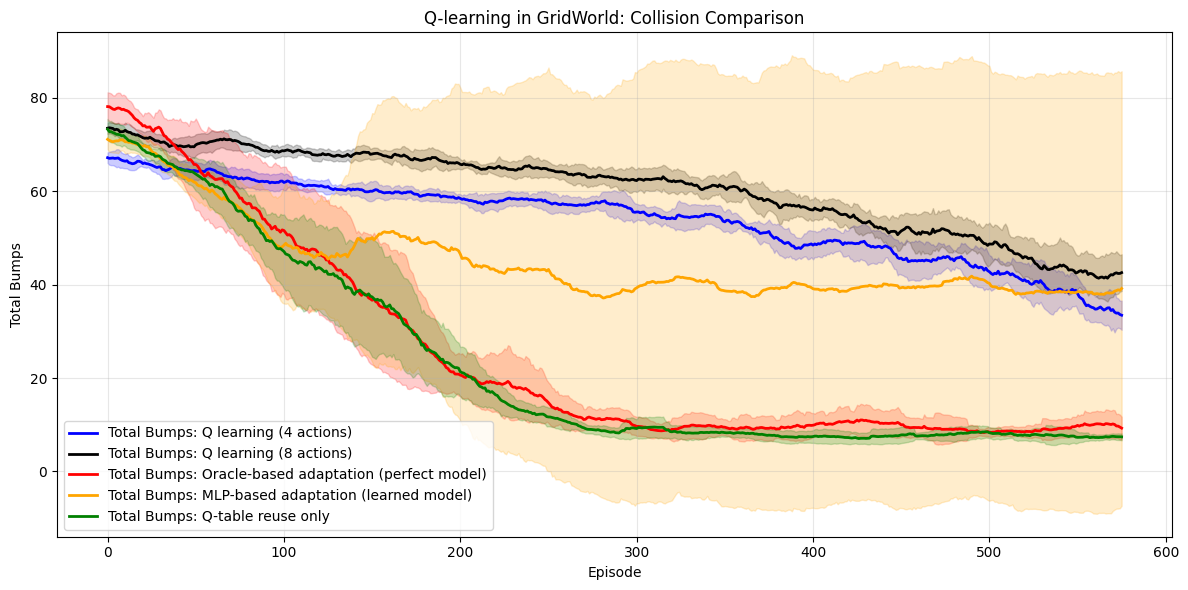

In [5]:
import copy
def run_multiple_experiments(n_runs=5, base_seed=123):
    """Run multiple experiments with different seeds and return statistics"""
    
    # Storage for all runs
    all_returns4 = []
    all_returns5plain = []
    all_returns5oracle = []
    all_returns5mlp = []
    all_returns5ignore = []
    all_bumps4 = []
    all_bumps5plain = []
    all_bumps5oracle = []
    all_bumps5mlp = []
    all_bumps5ignore = []
    
    for run in range(n_runs):
        current_seed = base_seed + run * 42
        # Reset random seeds
        rng = np.random.default_rng(current_seed)
        random.seed(current_seed)
        np.random.seed(current_seed)
        torch.manual_seed(current_seed)
        
        print(f"Running experiment {run + 1}/{n_runs}...")
        
        # 1. Q-learning with 4 actions
        agent_plain_4_action = QLearningAgent(grid_world, 4, seed=current_seed)
        agent_plain_4_action.train(ACTIONS_4, epsilon_greedy, BUMP_REWARD)
        results_plain = agent_plain_4_action.get_results(moving_average)
        all_returns4.append(results_plain['returns'])
        all_bumps4.append(results_plain['bumps'])
        
        # 2. Plain Q-learning with 8 actions
        agent_plain = QLearningAgent(grid_world, 8, seed=current_seed)
        agent_plain.train(ACTIONS_8, epsilon_greedy, BUMP_REWARD)
        results_plain = agent_plain.get_results(moving_average)
        all_returns5plain.append(results_plain['returns'])
        all_bumps5plain.append(results_plain['bumps'])
        
        # 3. Oracle Q-learning with 8 actions 
        oracle_agent_run = OracleQLearningAgent(grid_world, 8, base_q_table=copy.deepcopy(agent_plain_4_action.Q), seed=current_seed)
        oracle_agent_run.train_with_oracle(ACTIONS_8, epsilon_greedy, BUMP_REWARD, oracle_model,copy.deepcopy(agent_plain_4_action.Q))
        oracle_results_run = oracle_agent_run.get_results(moving_average)
        all_returns5oracle.append(oracle_results_run['returns'])
        all_bumps5oracle.append(oracle_results_run['bumps'])
        
        # 4. MLP Q-learning with 8 actions (only Q-table reuse)
        ignore_model_run = MLPQLearningAgent(grid_world, 8, base_q_table=copy.deepcopy(agent_plain_4_action.Q), seed=current_seed, use_model=True, use_conditional=False)
        ignore_model_run.train_with_learned_model(ACTIONS_8, epsilon_greedy, BUMP_REWARD, copy.deepcopy(agent_plain_4_action.Q))
        ignore_model_result_run = ignore_model_run.get_results(moving_average)
        all_returns5ignore.append(ignore_model_result_run['returns'])
        all_bumps5ignore.append(ignore_model_result_run['bumps'])
        
        # 5. NEW: MLP Q-learning with 8 actions (our approach)
        mlp_agent_run = MLPQLearningAgent(grid_world, 8, base_q_table=copy.deepcopy(agent_plain_4_action.Q), seed=current_seed, use_model=True, use_conditional=True)
        mlp_agent_run.train_with_learned_model(ACTIONS_8, epsilon_greedy, BUMP_REWARD, copy.deepcopy(agent_plain_4_action.Q))
        mlp_results_run = mlp_agent_run.get_results(moving_average)
        all_returns5mlp.append(mlp_results_run['returns'])
        all_bumps5mlp.append(mlp_results_run['bumps'])
    
    # Calculate statistics
    all_returns4 = np.array(all_returns4)
    all_returns5plain = np.array(all_returns5plain)
    all_returns5oracle = np.array(all_returns5oracle)
    all_returns5mlp = np.array(all_returns5mlp)
    all_returns5ignore = np.array(all_returns5ignore)
    all_bumps4 = np.array(all_bumps4)
    all_bumps5plain = np.array(all_bumps5plain)
    all_bumps5oracle = np.array(all_bumps5oracle)
    all_bumps5mlp = np.array(all_bumps5mlp)
    all_bumps5ignore = np.array(all_bumps5ignore)
    
    # Calculate moving averages for all runs
    ma_w = 25
    all_ret_ma4 = np.array([moving_average(returns, w=ma_w) for returns in all_returns4])
    all_ret_ma5plain = np.array([moving_average(returns, w=ma_w) for returns in all_returns5plain])
    all_ret_ma5oracle = np.array([moving_average(returns, w=ma_w) for returns in all_returns5oracle])
    all_ret_ma5mlp = np.array([moving_average(returns, w=ma_w) for returns in all_returns5mlp])
    all_ret_ma5ignore = np.array([moving_average(returns, w=ma_w) for returns in all_returns5ignore])
    
    all_bumps4_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps4])
    all_bumps5plain_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5plain])
    all_bumps5oracle_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5oracle])
    all_bumps5mlp_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5mlp])
    all_bumps5ignore_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5ignore])
    
    return {
        'returns': {
            '4_actions': {'mean': np.mean(all_ret_ma4, axis=0), 'std': np.std(all_ret_ma4, axis=0)},
            '5_plain': {'mean': np.mean(all_ret_ma5plain, axis=0), 'std': np.std(all_ret_ma5plain, axis=0)},
            '5_oracle': {'mean': np.mean(all_ret_ma5oracle, axis=0), 'std': np.std(all_ret_ma5oracle, axis=0)},
            '5_mlp': {'mean': np.mean(all_ret_ma5mlp, axis=0), 'std': np.std(all_ret_ma5mlp, axis=0)},
            '5_ignore': {'mean': np.mean(all_ret_ma5ignore, axis=0), 'std': np.std(all_ret_ma5ignore, axis=0)}
        },
        'bumps': {
            '4_actions': {'mean': np.mean(all_bumps4_avg, axis=0), 'std': np.std(all_bumps4_avg, axis=0)},
            '5_plain': {'mean': np.mean(all_bumps5plain_avg, axis=0), 'std': np.std(all_bumps5plain_avg, axis=0)},
            '5_oracle': {'mean': np.mean(all_bumps5oracle_avg, axis=0), 'std': np.std(all_bumps5oracle_avg, axis=0)},
            '5_mlp': {'mean': np.mean(all_bumps5mlp_avg, axis=0), 'std': np.std(all_bumps5mlp_avg, axis=0)},
            '5_ignore': {'mean': np.mean(all_bumps5ignore_avg, axis=0), 'std': np.std(all_bumps5ignore_avg, axis=0)}
        }
    }

# Run multiple experiments
print("Running multiple experiments for statistical analysis...")
stats = run_multiple_experiments(n_runs=10)  # Reduced runs for faster execution

# Plot results with shaded error bars
def plot_with_shaded_errors(stats, figsize=(12, 6)):
    """Plot results with shaded error bars"""
    
    # Returns plot
    plt.figure(figsize=figsize)
    
    # Calculate x-axis for each series (they might have different lengths due to moving average)
    episodes_total = EPISODES
    ma_w = 25
    
    # Plot each method with shaded error bars
    methods = [
        ('4_actions', 'Q learning (4 actions)', 'blue'),
        ('5_plain', 'Q learning (8 actions)', 'black'), 
        ('5_oracle', 'Oracle-based adaptation (perfect model)', 'red'),
        ('5_mlp', 'MLP-based adaptation (learned model)', 'orange'),
        ('5_ignore', 'Q-table reuse only', 'green')
    ]
    
    for method_key, label, color in methods:
        mean_vals = stats['returns'][method_key]['mean']
        std_vals = stats['returns'][method_key]['std']
        x_vals = np.arange(episodes_total - len(mean_vals), episodes_total)
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Return: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Discounted return')
    plt.title('Q-learning in GridWorld: Comparison of Adaptation Methods')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Bumps plot
    plt.figure(figsize=figsize)
    
    for method_key, label, color in methods:
        mean_vals = stats['bumps'][method_key]['mean']
        std_vals = stats['bumps'][method_key]['std']
        x_vals = np.arange(len(mean_vals))
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Total Bumps: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Bumps')
    plt.title('Q-learning in GridWorld: Collision Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the results with shaded error bars
plot_with_shaded_errors(stats)